# Model building

## Needed Theory
As explained before, we'll train a neural network to learn an embeddings space to represent images so that after we can use it to compare two input images $=>$ more formally a siamese network, with that saying what we 're going to do is use a pretrained model including the early layers and maybe exclude some of the last layers.

For the sake of simplicity here's an example of the architecture: 

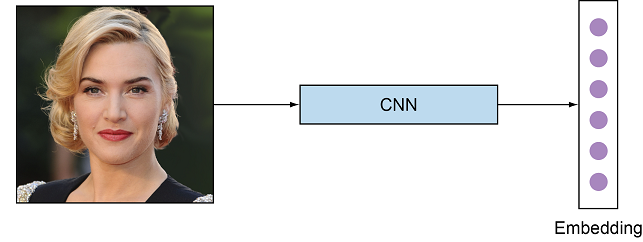

The embeddings can be seen as a vector space, and so our goal here is to change the images representation so that similar images have close representation here's what that looks like visually: 

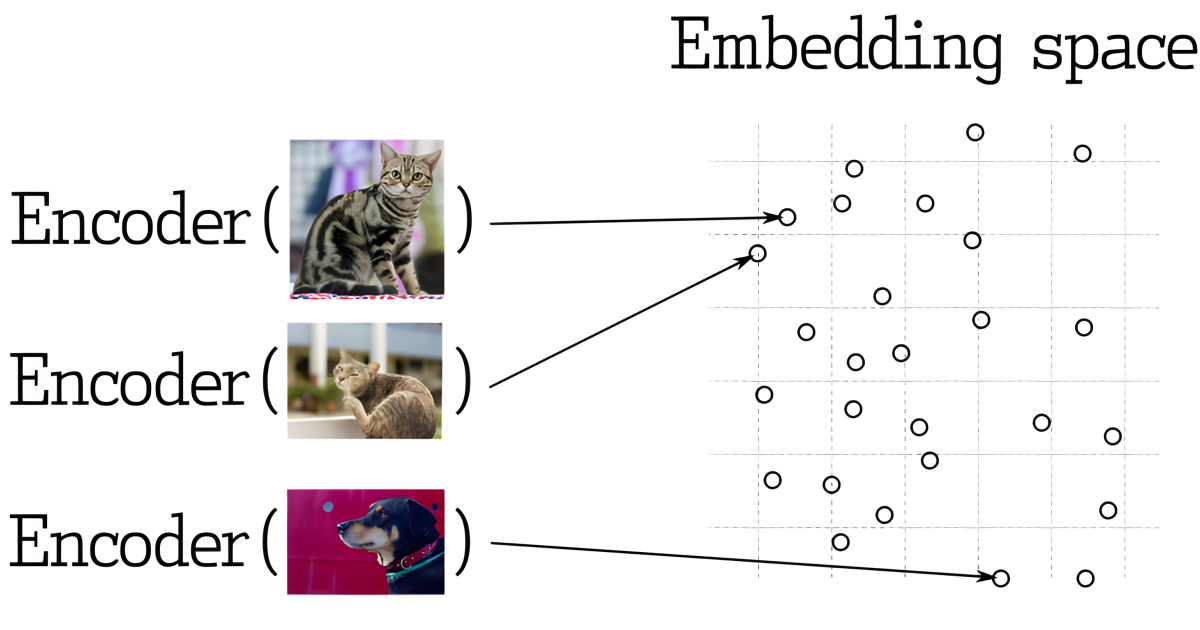


### Similarity Formalism
So far researchers have defined similarity differently, the one we'll use for this notebook is this intuitive one, $P(Img_1 = Img_2)$ : Probability of a the first image being the same as the second, this might make your brain click since you already know the sigmoid activation function, here's how the model in this case is going to work:

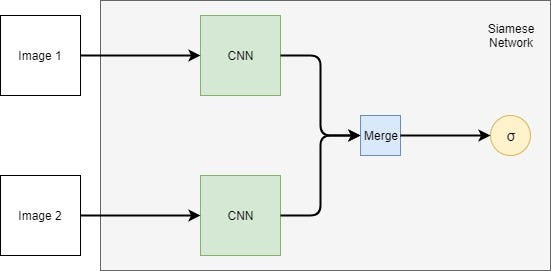

- Note that there are other several ways to formalize similarity that maybe we can use in this notebook such the cosine similarity and the euclidean distance.

### Transfer Learning 
As an inspiration from the cited ressources, We'll use the pretrained VGG16 model, at first glance this might seem contraversal and question like this might click on your head: Why the need of such a big model while we 've got such a huge dataset of 13k images of 5k people, well it's all about the context we're working on, in fact we've got a limited number of images of the same person as we said earlier we're hoping to fight the One-shot learning problem.
here's an architecture similar of what we're going to do seeking a high accuracy score:

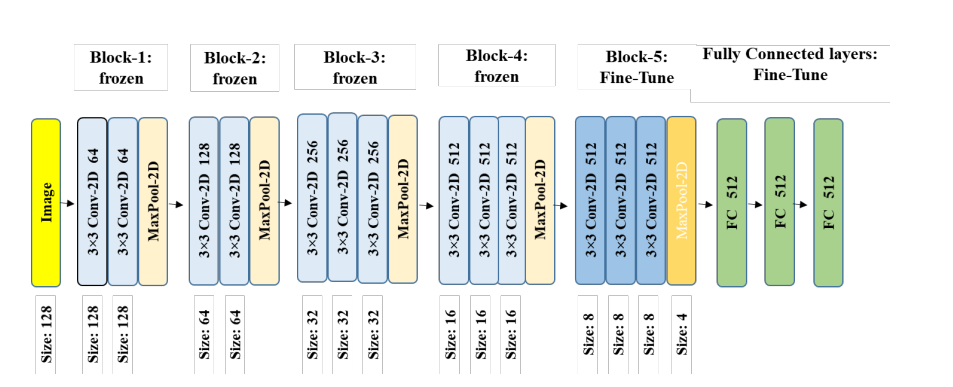

### Preprocessing
Note that the use of VGG16 network implies the need of having images with size $224 \times 244$. We'll explore and preprocess data so that can be used.
The dataset provides two recommended configurations for developing training and testing sets: pairs or people. Since our goal is to predict similarity between pairs of face images, the "pairs" configuration is more suitable.

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
lfw_allnames = pd.read_csv("../input/lfw-dataset/lfw_allnames.csv")
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")

In [6]:
pairs.describe()

,imagenum1,Unnamed: 3
count,6000.000000,3000.00000
mean,2.421500,1.52900
std,6.473187,2.67299
min,1.000000,1.00000
25%,1.000000,1.00000
50%,1.000000,1.00000
75%,2.000000,1.00000
max,203.000000,64.00000


As the dataset suggests: 
- matchpairsDevTrain.csv and mismatchpairsDevTest will be used for training.
- matchpairsDevTest.csv and mismatchpairsDevTest will be used for training.

In [7]:
matchpairsDevTest = pd.read_csv("../input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTrain.csv")

In [8]:
# Data format
matchpairsDevTrain.head()

,name,imagenum1,imagenum2
0,Aaron_Peirsol,1,2
1,Aaron_Peirsol,3,4
2,Aaron_Sorkin,1,2
3,Abdel_Nasser_Assidi,1,2
4,Abdullah,1,3


In [9]:
# Data statistical infos
matchpairsDevTest.describe()

,imagenum1,imagenum2
count,500.000000,500.000000
mean,2.634000,5.178000
std,4.233662,7.419732
min,1.000000,2.000000
25%,1.000000,2.000000
50%,1.000000,3.000000
75%,2.000000,5.000000
max,41.000000,108.000000


In [10]:
# Missing values check
print(matchpairsDevTrain.isnull().sum())
print(matchpairsDevTest.isnull().sum())
print(mismatchpairsDevTrain.isnull().sum())
print(mismatchpairsDevTest.isnull().sum())

name         0
imagenum1    0
imagenum2    0
dtype: int64
name         0
imagenum1    0
imagenum2    0
dtype: int64
name         0
imagenum1    0
name.1       0
imagenum2    0
dtype: int64
name         0
imagenum1    0
name.1       0
imagenum2    0
dtype: int64


Text(0.5, 1.0, 'Null Value Counts for Different DataFrames')

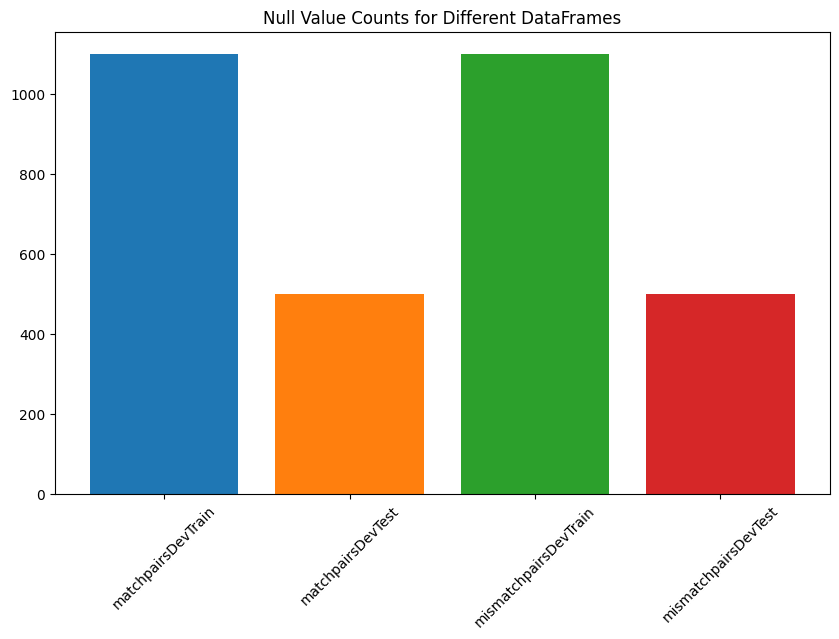

In [11]:
# Missing values check by visualization
plt.figure(figsize=(10, 6))
plt.bar('matchpairsDevTrain', matchpairsDevTrain.isnull().count())
plt.bar('matchpairsDevTest', matchpairsDevTest.isnull().count())
plt.bar('mismatchpairsDevTrain', mismatchpairsDevTrain.isnull().count())
plt.bar('mismatchpairsDevTest', mismatchpairsDevTest.isnull().count())
plt.xticks(rotation=45)
plt.title('Null Value Counts for Different DataFrames')

No missing values !

In [12]:
import PIL.Image
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
# Function to load and preprocess an image
def load_image(img_path):
    img = PIL.Image.open(img_path)
    img = img.convert('RGB') # Convert to RGB if the image has other color modes
    img = transform(img)
    return img

In [15]:
!wget -O test_img.jpg "https://images.unsplash.com/photo-1542909168-82c3e7fdca5c?q=80&w=1000&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8OHx8ZmFjZXxlbnwwfHwwfHx8MA%3D%3D"

--2024-04-25 14:31:27--  https://images.unsplash.com/photo-1542909168-82c3e7fdca5c?q=80&w=1000&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8OHx8ZmFjZXxlbnwwfHwwfHx8MA%3D%3D
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85289 (83K) [image/jpeg]
Saving to: 'test_img.jpg'

test_img.jpg        100%[===================>]  83.29K  --.-KB/s    in 0.003s  

2024-04-25 14:31:27 (32.1 MB/s) - 'test_img.jpg' saved [85289/85289]



In [16]:
def visualize_image(image_tensor):
    image_numpy = image_tensor.numpy()
    image_numpy = image_numpy.transpose((1, 2, 0)) # Transpose the dimensions to (height, width, channels)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image_numpy = (image_numpy * std) + mean
    image_numpy = np.clip(image_numpy, 0, 1)  # Clip the values to be within [0, 1]
    plt.imshow(image_numpy)
    plt.axis('off')
    plt.show()

In [17]:
# Test the load_image function
load_image("test_img.jpg")

tensor([[[ 0.3481,  0.3481,  0.3481,  ..., -0.9877, -0.9877, -1.0048],
         [ 0.3652,  0.3652,  0.3652,  ..., -0.9705, -0.9877, -1.0048],
         [ 0.3652,  0.3823,  0.3652,  ..., -0.9705, -0.9877, -0.9877],
         ...,
         [-0.4739, -0.4739, -0.4739,  ..., -1.2617, -1.2788, -1.2959],
         [-0.4911, -0.4911, -0.4739,  ..., -1.2788, -1.2959, -1.2959],
         [-0.5082, -0.5082, -0.4911,  ..., -1.2959, -1.2959, -1.2959]],

        [[ 0.5203,  0.5203,  0.5203,  ..., -0.8803, -0.8803, -0.8978],
         [ 0.5378,  0.5378,  0.5378,  ..., -0.8627, -0.8803, -0.8978],
         [ 0.5378,  0.5553,  0.5378,  ..., -0.8627, -0.8803, -0.8803],
         ...,
         [-0.3375, -0.3375, -0.3375,  ..., -1.1253, -1.1429, -1.1604],
         [-0.3725, -0.3725, -0.3550,  ..., -1.1429, -1.1604, -1.1604],
         [-0.3901, -0.3901, -0.3725,  ..., -1.1604, -1.1604, -1.1604]],

        [[ 0.7228,  0.7228,  0.7228,  ..., -0.6890, -0.6890, -0.7064],
         [ 0.7402,  0.7402,  0.7402,  ..., -0

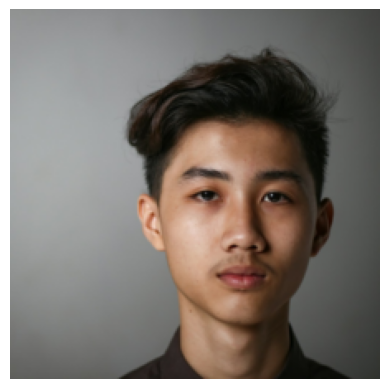

In [18]:
# Test visualize function
visualize_image(load_image("test_img.jpg"))

In [19]:
# Function to create pairs of images and labels
def create_pairs(df, is_match):
    pairs = []
    labels = []
    for _, row in df.iterrows():
        # Get the name and image numbers for the first image
        name1 = row['name']
        imagenum1 = row['imagenum1']
        # Get the name and image numbers for the second image
        if is_match:
            # For matched pairs, both images are of the same person
            name2 = name1
            imagenum2 = row['imagenum2']
            label = 1
        else:
            # For mismatched pairs, the images are of different people
            name2 = row['name.1'] if 'name.1' in df.columns else row['name']
            imagenum2 = row['imagenum2']
            label = 0
        # Load images
        img1_path = f"../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/{name1}/{name1}_{imagenum1:04d}.jpg"
        img2_path = f"../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/{name2}/{name2}_{imagenum2:04d}.jpg"
        img1 = load_image(img1_path)
        img2 = load_image(img2_path)
        # Append the pair and label to the respective lists
        pairs.append([img1, img2])
        labels.append(label)

    # Convert the lists to NumPy arrays
    pairs = np.array(pairs)
    labels = np.array(labels)

    return pairs, labels.astype("float32")

In [20]:
train_matched_pairs, train_matched_labels = create_pairs(matchpairsDevTrain, is_match=True)
train_mismatched_pairs, train_mismatched_labels = create_pairs(mismatchpairsDevTrain, is_match=False)
test_matched_pairs, test_matched_labels = create_pairs(matchpairsDevTest, is_match=True)
test_mismatched_pairs, test_mismatched_labels = create_pairs(mismatchpairsDevTest, is_match=False)

(3, 224, 224)
(3, 224, 224)


Text(0.5, 0.98, 'Example of matching pairs')

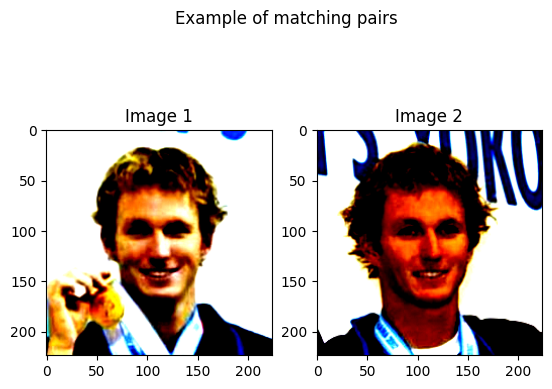

In [21]:
img1, img2 = train_matched_pairs[0]
print(img1.shape)
print(img2.shape)
img1, img2 = img1.transpose((1, 2, 0)), img2.transpose((1, 2, 0))
# Display matching pairs
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2')
plt.suptitle('Example of matching pairs')

Text(0.5, 0.98, 'Example of mismatching pairs')

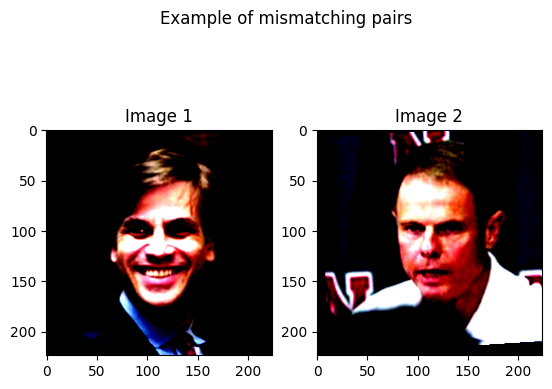

In [22]:
img1, img2 = train_mismatched_pairs[1]
img1, img2 = img1.transpose((1, 2, 0)), img2.transpose((1, 2, 0))

# Display mismatching pairs
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Image 2')
plt.suptitle('Example of mismatching pairs')

In [23]:
class SiameseDataset(Dataset):
    def __init__(self, matched_pairs, matched_labels, mismatched_pairs, mismatched_labels):
        self.pairs = np.concatenate((matched_pairs, mismatched_pairs), axis=0)
        self.labels = np.concatenate((matched_labels, mismatched_labels), axis=0)
        
        # Shuffle the data
        indices = np.arange(len(self.pairs))
        random.shuffle(indices)
        self.pairs = self.pairs[indices]
        self.labels = self.labels[indices]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img1 = self.pairs[idx][0]
        img2 = self.pairs[idx][1]
        label = self.labels[idx]
        
        # Convert images to PyTorch tensors
        img1 = transforms.ToTensor()(img1)
        img2 = transforms.ToTensor()(img2)

        return img1, img2, label

In [82]:
train_dataset = SiameseDataset(train_matched_pairs, train_matched_labels,
                                train_mismatched_pairs, train_mismatched_labels)

test_dataset = SiameseDataset(test_matched_pairs, test_matched_labels,
                               test_mismatched_pairs, test_mismatched_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [83]:
# Function to visualize a pair of images and their label
def visualize_pair(img1, img2, label):
    # Convert the image tensors to NumPy arrays
    img1 = img1.numpy().transpose((2, 0, 1))
    img2 = img2.numpy().transpose((2, 0, 1))
    # Display the images
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title('Image 1')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title('Image 2')
    plt.axis('off')
    # Set the title based on the label
    if label == 1:
        plt.suptitle('Example of matching pair')
    else:
        plt.suptitle('Example of mismatching pair')

    plt.show()

In [84]:
for img1, img2, label in train_loader:
    print(img1.shape)
    print(img2.shape)
    break

torch.Size([32, 224, 3, 224])
torch.Size([32, 224, 3, 224])


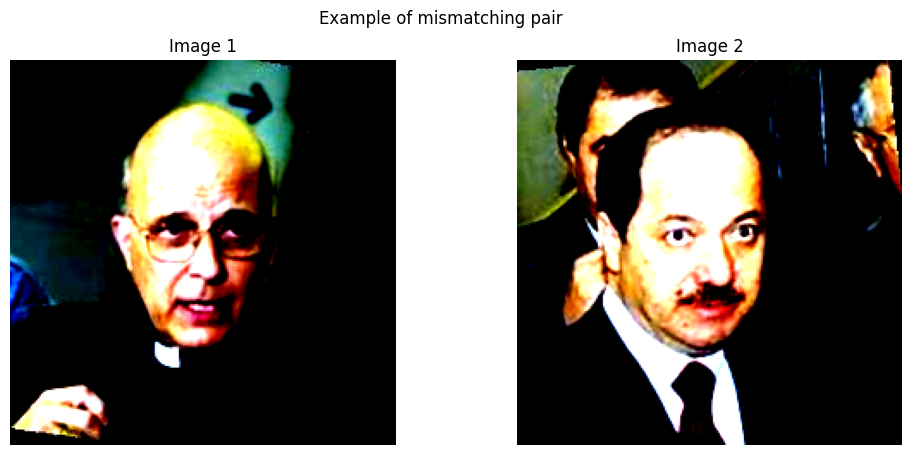

In [85]:
# Visualize a pair
for img1, img2, label in train_loader:
    visualize_pair(img1[0], img2[0], label[0])
    break

### Model Building

In [86]:
!pip install torchsummary

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary

Here's how you can have an idea about the model's architecture:

In [88]:
# Load the VGG16 model and freeze its layers
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)
summary(vgg16, (3, 224, 224)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Define the siamese network logic, use VGG16 as a feature extarcor. Use the learned features and adding some fully connected layers to compute the vectors representations

In [95]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.fc_in_features = 2 * 512
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.vgg.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.vgg(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        output = torch.cat((output1, output2), 1)

        # reshape the concatenated output to match the linear layer's input size
        output = output.view(output.size(0), -1)

        # pass the reshaped tensor to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)

        return output

#### Contrastive Loss: A Comprehensive Guide
The contrastive loss is a specific loss function for the face verification tasks, what it does is motivate the model to minimize the distance between similar (positive) pairs of inputs while maximizing the distance between dissimilar (negative) pairs.

The contrastive loss for a pair of inputs (x1, x2) and their similarity label Y can be formulated as:

$L(x_1, x_2, Y) = (1 - Y) \times D^2 + Y \times \max(0, m - D)^2$

Where:
- D = distance between the feature vectors of x1 and x2 

- Y = 0 if x1 and x2 are dissimilar (negative pair), 1 if they are similar (positive pair)

- m = margin value, enforcing a minimum distance between negative pairs


In [96]:
def contrastive_loss(output, labels, margin=1.0):
    euclidean_distance = torch.pairwise_distance(output[:, 0].unsqueeze(1), output[:, 1].unsqueeze(1))
    loss_contrastive = torch.mean((1 - labels) * torch.pow(euclidean_distance, 2) +
                                  labels * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

In [103]:
# Define the model, loss function, optimizer, and other hyperparameters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siamese_model = SiameseNetwork().to(device)
optimizer = torch.optim.Adam(siamese_model.parameters(), lr= 0.000003)
criterion = nn.BCELoss()
batch_size = 32
epochs = 7

In [104]:
# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    running_accuracy = 0.0

    # Iterate over the train_loader
    for batch_idx, (img1, img2, labels) in enumerate(train_loader): 
        img1 = img1.permute(0, 2, 1, 3)
        img2 = img2.permute(0, 2, 1, 3)
        img1 = img1.to(device)  
        img2 = img2.to(device)  
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = siamese_model(img1, img2).squeeze()
        labels = labels.squeeze()

        # Compute the loss
        loss = criterion(output, labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute the running loss and accuracy
        running_loss += loss.item()
        running_accuracy += (output.squeeze() > 0.5).float().eq(labels.float()).sum().item() / batch_size

    # Print the average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch 1/7, Loss: 0.7212, Accuracy: 0.5095
Epoch 2/7, Loss: 0.5519, Accuracy: 0.7695
Epoch 3/7, Loss: 0.4166, Accuracy: 0.9103
Epoch 4/7, Loss: 0.2856, Accuracy: 0.9733
Epoch 5/7, Loss: 0.1731, Accuracy: 0.9923
Epoch 6/7, Loss: 0.0973, Accuracy: 0.9959
Epoch 7/7, Loss: 0.0525, Accuracy: 0.9964


In [105]:
siamese_model.eval()
criterion = nn.CrossEntropyLoss()
correct = 0
total = 0
test_loss = 0
# Iterate over the test dataset
with torch.no_grad():
    for (img1, img2, labels) in test_loader: 
        img1 = img1.permute(0, 2, 1, 3)
        img2 = img2.permute(0, 2, 1, 3)
        img1 = img1.to(device)  
        img2 = img2.to(device)  
        labels = labels.to(device)

        output = siamese_model(img1, img2).squeeze()
        labels = labels.squeeze()
        loss = criterion(output, labels) 
        test_loss += loss.item() 

        predicted = torch.where(output > 0.5, 1, 0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() 

    # Compute the average loss and accuracy
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 1.7368, Test Accuracy: 52.70%
